# 3d mortar assembly

Author: Jukka Aho

**Abstract**: Mortar assembly for 3d problems.

In [1]:
using JuliaFEM

In [2]:
nodes = Vector{Float64}[
    [0.0, 0.0, 0.0],
    [3.0, 0.0, 0.0],
    [0.0, 3.0, 0.0],
    [-1.0,  1.0, 0.1],
    [ 2.0, -0.5, 0.1],
    [ 2.0,  2.0, 0.1]]

mel = JuliaFEM.Core.Tri3([4, 5, 6])
mel["geometry"] = Vector{Float64}[nodes[4], nodes[5], nodes[6]]

sel = JuliaFEM.Core.Tri3([1, 2, 3])
sel["geometry"] = Vector{Float64}[nodes[1], nodes[2], nodes[3]]
R = [
    0.0 1.0 0.0
    0.0 0.0 1.0
    1.0 0.0 0.0]
sel["nodal ntsys"] = Matrix{Float64}[R, R, R]
sel["master elements"] = JuliaFEM.Core.Element[mel]

1-element Array{JuliaFEM.Core.Element{E<:JuliaFEM.Core.AbstractElement},1}:
 JuliaFEM.Core.Element{JuliaFEM.Core.Tri3}([4,5,6],Dict{ASCIIString,JuliaFEM.Core.Field{A<:Union{JuliaFEM.Core.Continuous,JuliaFEM.Core.Discrete},B<:Union{JuliaFEM.Core.Constant,JuliaFEM.Core.Variable},C<:Union{JuliaFEM.Core.TimeInvariant,JuliaFEM.Core.TimeVariant}}}("geometry"=>JuliaFEM.Core.Field{JuliaFEM.Core.Discrete,JuliaFEM.Core.Variable,JuliaFEM.Core.TimeInvariant}([[-1.0,1.0,0.1],[2.0,-0.5,0.1],[2.0,2.0,0.1]])))

In [3]:
time = 0.0
x0, Q = JuliaFEM.Core.create_auxiliary_plane(sel, time)
S = Vector{Float64}[]
for p in sel("geometry", time)
    push!(S, JuliaFEM.Core.project_point_to_auxiliary_plane(p, x0, Q))
end

M = Vector{Float64}[]
for p in mel("geometry", time)
    push!(M, JuliaFEM.Core.project_point_to_auxiliary_plane(p, x0, Q))
end

#S = Matrix[x' for x in S]
#S, M
S = reshape([S...;], 2, 3)
M = reshape([M...;], 2, 3)
P, neighbours = JuliaFEM.Core.clip_polygon(S, M)
C = JuliaFEM.Core.calculate_polygon_centerpoint(P)
S, M, P, neighbours, C

(
2x3 Array{Float64,2}:
 -1.0   2.0  -1.0
 -1.0  -1.0   2.0,

2x3 Array{Float64,2}:
 -2.0   1.0  1.0
  0.0  -1.5  1.0,

2x6 Array{Float64,2}:
 -1.0   0.0   1.0  1.0  0.25  -1.0     
 -0.5  -1.0  -1.0  0.0  0.75   0.333333,

3x3 Array{Int64,2}:
 1  0  1
 1  1  0
 0  1  1,

[0.039743589743589755,-0.1952991452991453])

INFO: npts = 6


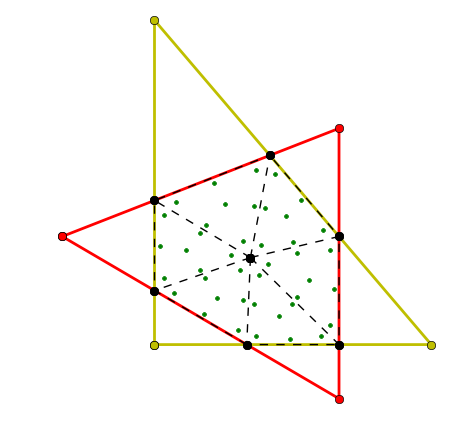

(-2.1,2.1,-1.6,2.1)

In [4]:
using PyPlot
fig = figure(figsize=(5.0, 5.0))
plot(S[1, [1, 2, 3, 1]]', S[2, [1, 2, 3, 1]]', "-yo", lw=2.0)
plot(M[1, [1, 2, 3, 1]]', M[2, [1, 2, 3, 1]]', "-ro", lw=2.0)
#plot(P[1, [1, 2, 3, 4, 5, 6, 1]]', P[2, [1, 2, 3, 4, 5, 6, 1]]', "-k", lw=2.5)
npts = size(P, 2)
info("npts = $npts")
# loop over cells
ips = JuliaFEM.Core.get_integration_points(JuliaFEM.Core.Tri3, Val{5})
#info("ips = $ips")
SM = zeros(3, 3)
SS = zeros(3, 3)
for i=1:npts
    xvec = [C[1], P[1, i], P[1, mod(i, npts)+1]]
    yvec = [C[2], P[2, i], P[2, mod(i, npts)+1]]
    plot(xvec, yvec, "--ko", lw=1.0)
    X = hcat(xvec, yvec)'
    geom = JuliaFEM.Core.Field(Vector{Float64}[X[:,i] for i=1:size(X,2)])
    #info("geom = $geom")
    for ip in ips
        dN = JuliaFEM.Core.get_dbasis(JuliaFEM.Core.Tri3, ip.xi)
        J = sum([kron(dN[:,j], geom[j]') for j=1:length(geom)])
        w = ip.weight*det(J)
        x = vec(JuliaFEM.Core.get_basis(JuliaFEM.Core.Tri3, ip.xi)*geom)
        plot(x[1], x[2], ".g")
        theta1 = JuliaFEM.Core.project_point_from_plane_to_surface(x, x0, Q, sel, time)
        N1 = sel(theta1[2:3], time)
        theta2 = JuliaFEM.Core.project_point_from_plane_to_surface(x, x0, Q, mel, time)
        N2 = mel(theta2[2:3], time)
        SS += w*N1'*N1
        SM += w*N1'*N2
    end
end
plot(C[1], C[2], "ko")
xlim(-2.1, 2.1)
ylim(-1.6, 2.1)
axis("off")

In [5]:
info("SS = \n$SS")
info("SM = \n$SM")

INFO: SS = 
[0.5123885459533705 0.29124871399177565 0.23957261659808454
 0.29124871399177565 0.40967399691358797 0.23773469650206241
 0.23957261659808454 0.23773469650206241 0.2491587362825836]
INFO: SM = 
[0.4042245370370448 0.38539094650206535 0.2535943930041208
 0.21609760802469608 0.37920524691358753 0.3433545524691425
 0.24657600308642466 0.1835519547325143 0.2963380915637917]
